In [234]:
from pandas import DataFrame,read_csv,concat
from numpy import argmax,cumsum
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.losses import Huber
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
import seaborn as sns



from joblib import dump,load

##### Read the data from the CSV value and check for the null values

In [235]:
salary_data = read_csv('content/salary.csv')

salary_data.head(4)


,Age,Gender,Education Level,Job Title,Years of Experience,Salary
0,32.0,Male,Bachelor's,Software Engineer,5.0,90000.0
1,28.0,Female,Master's,Data Analyst,3.0,65000.0
2,45.0,Male,PhD,Senior Manager,15.0,150000.0
3,36.0,Female,Bachelor's,Sales Associate,7.0,60000.0


In [236]:

salary_data.isnull().sum()

Age                    2
Gender                 2
Education Level        2
Job Title              2
Years of Experience    2
Salary                 2
dtype: int64

##### Since there is 2 null values we are going to drop this data

In [237]:

null_indices = salary_data[salary_data.isnull().any(axis=1)].index.tolist()
print("Null values indices:", null_indices)

Null values indices: [172, 260]


In [238]:
salary_data = salary_data.drop(index=null_indices,axis=1)
salary_data.isnull().sum()

Age                    0
Gender                 0
Education Level        0
Job Title              0
Years of Experience    0
Salary                 0
dtype: int64

##### Created a seperate salary data dataframe so that we can have output training

In [239]:

target_salary_data = salary_data['Salary']
salary_data = salary_data.drop(columns=['Salary'],axis=1)

target_salary_data.head(5)

0     90000.0
1     65000.0
2    150000.0
3     60000.0
4    200000.0
Name: Salary, dtype: float64

##### Plotting the graph for every feature to obsserve the trend with Salary data

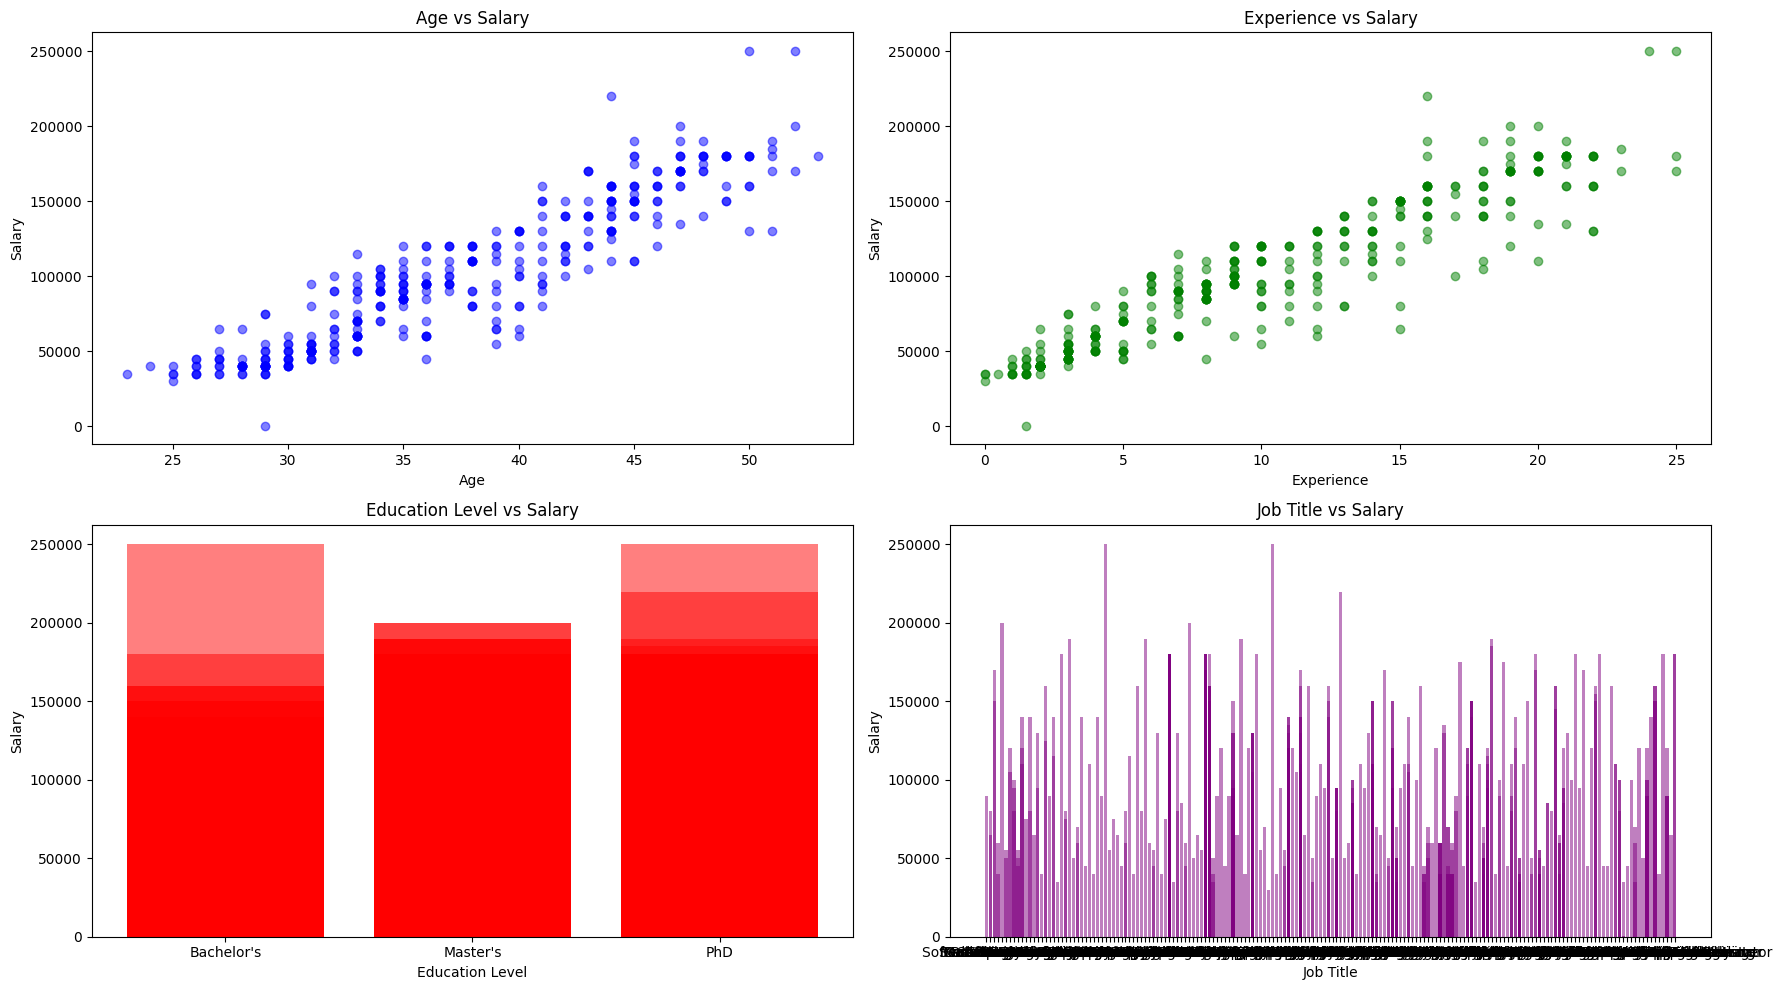

In [240]:


plt.figure(figsize=(18, 10))
plt.subplot(2, 2, 1)
plt.scatter(salary_data["Age"], target_salary_data, color='blue', alpha=0.5)
plt.title("Age vs Salary")
plt.xlabel("Age")
plt.ylabel("Salary")

plt.subplot(2, 2, 2)
plt.scatter(salary_data["Years of Experience"], target_salary_data, color='green', alpha=0.5)
plt.title("Experience vs Salary")
plt.xlabel("Experience")
plt.ylabel("Salary")

plt.subplot(2, 2, 3)
plt.bar(salary_data["Education Level"], target_salary_data, color='red', alpha=0.5)
plt.title("Education Level vs Salary")
plt.xlabel("Education Level")
plt.ylabel("Salary")

plt.subplot(2, 2, 4)
plt.bar(salary_data["Job Title"], target_salary_data, color='purple', alpha=0.5)
plt.title("Job Title vs Salary")
plt.xlabel("Job Title")
plt.ylabel("Salary")

plt.tight_layout()
plt.show()

##### There are data which may contains outlier and each and every data is in different scale so to get the best result we are going to normalize it.

In [241]:

scaler = MinMaxScaler()
target_salary_data = scaler.fit_transform(target_salary_data.values.reshape(-1, 1))

dump(scaler, 'target_salary_scaler.pkl')

['target_salary_scaler.pkl']

##### There are many categorical feature present in the dataset so to convert them to numerical form we are going to perform onehot enocoding also we will save all these scaling and encoding model to be used to host the ml project

In [242]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False,dtype='int')

encoded_cols = ["Age", "Education Level", "Job Title","Gender"]
encoder.fit(salary_data[encoded_cols])


encoded_data = encoder.transform(salary_data[encoded_cols])
encoded_df = DataFrame(encoded_data, columns=encoder.get_feature_names_out(encoded_cols),dtype=int)

encoded_df = encoded_df.astype(int)

salary_data = concat([
    salary_data.drop(columns=encoded_cols).reset_index(drop=True),
    encoded_df.reset_index(drop=True)
], axis=1)

dump(encoder, 'encoder.pkl')

['encoder.pkl']

##### Before PCA we will normalize the data so that in pca we can get better and clearer pattern

In [243]:
scaler_pca = MinMaxScaler()
salary_data = scaler_pca.fit_transform(salary_data.values)
dump(scaler_pca, 'salary_scaler.pkl')

['salary_scaler.pkl']

In [244]:
train_salary_data, test_salary_data,train_target_salary_data,test_target_salary_data = train_test_split(salary_data, target_salary_data, test_size=0.2, random_state=42)

In [245]:
pca = PCA(n_components=211)

pca.fit(train_salary_data)
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = cumsum(explained_variance_ratio)
optimal_k = argmax(cumulative_variance >= 0.95) + 1
print(f"Optimal number of components (k) for 95% variance: {optimal_k}")
pca = PCA(n_components=optimal_k)
pca_train_salary_data = pca.fit_transform(train_salary_data)
pca_train_salary_data


Optimal number of components (k) for 95% variance: 118


array([[-7.42402149e-01,  4.08819059e-01, -8.68582935e-02, ...,
        -4.37557010e-17,  9.23095857e-18,  1.86165849e-16],
       [-7.26868678e-01,  3.83505024e-01, -2.14465468e-02, ...,
        -1.94752491e-16,  1.70400766e-16,  2.15215627e-18],
       [ 6.93893073e-01,  6.72438473e-01, -1.26536865e-01, ...,
         9.94024016e-02, -6.41627307e-02,  4.15999146e-02],
       ...,
       [-7.27484300e-01,  3.98941358e-01, -5.90356131e-02, ...,
        -1.31838984e-16,  1.12757026e-17, -1.35308431e-16],
       [ 7.76612799e-01, -5.32419999e-01,  1.16592617e+00, ...,
        -4.68375339e-17,  9.02056208e-17,  1.70002901e-16],
       [ 8.14366221e-01, -9.23798650e-01, -3.95586471e-01, ...,
         1.97862568e-02,  4.02691245e-02,  7.01232948e-03]])

/var/folders/zw/wpbmbv6s62vc85qfn9szsqgm0000gn/T/ipykernel_33933/1278148663.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter3D(
/var/folders/zw/wpbmbv6s62vc85qfn9szsqgm0000gn/T/ipykernel_33933/1278148663.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


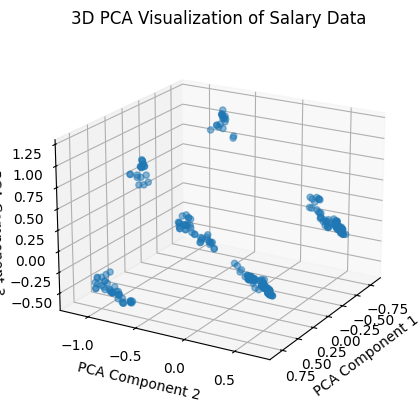

In [246]:

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter3D(
    pca_train_salary_data[:, 0],
    pca_train_salary_data[:, 1],
    pca_train_salary_data[:, 2],
    cmap='viridis',
    alpha=0.5
)
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
ax.set_title('3D PCA Visualization of Salary Data')
ax.view_init(elev=20, azim=30)
fig.show()




##### We are now using ANN model as neural network is good at finding a pattern in the data, and based on the eda intutively the data is more or less very linear in nature

##### We are going to create a 2 hidden layer, 1 input layer and 1 output layer

In [247]:
model = Sequential(
    [
        Dense(147, input_shape=(pca_train_salary_data.shape[1],),activation = "relu"),
        Dense(45, activation="relu"),
        Dense(6, activation="relu"),
        Dense(1, activation="relu"),
    ]
)

/Users/fastasturtle/Documents/MTech/Assignment/ML/.venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [248]:
model.compile(loss = Huber(delta=0.05), optimizer="adam", metrics=["mean_absolute_error"])

In [249]:
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_28 (Dense)                │ (None, 147)            │        17,493 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 45)             │         6,660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 6)              │           276 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │             7 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,436 (95.45 KB)

 Trainable params: 24,436 (95.45 KB)

 Non-trainable params: 0 (0.00 B)

In [250]:
train_salary_data.shape

(298, 211)

In [251]:
history = model.fit(pca_train_salary_data, train_target_salary_data,  epochs=100, validation_split=0.1)

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0129 - mean_absolute_error: 0.2824 - val_loss: 0.0132 - val_mean_absolute_error: 0.2865
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0097 - mean_absolute_error: 0.2182 - val_loss: 0.0109 - val_mean_absolute_error: 0.2413
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0079 - mean_absolute_error: 0.1807 - val_loss: 0.0087 - val_mean_absolute_error: 0.1979
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0062 - mean_absolute_error: 0.1474 - val_loss: 0.0063 - val_mean_absolute_error: 0.1488
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0051 - mean_absolute_error: 0.1245 - val_loss: 0.0051 - val_mean_absolute_error: 0.1239
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0041 - mean_absolute_error: 0.1030 - val_loss: 0.0047 - val_mean_absolute_error: 0.1148
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0035 - mean_absolute_error: 0.0897 - val_loss: 0.004

In [258]:
pca_test_salary_data = pca.transform(test_salary_data)

In [253]:
los = model.evaluate(pca_test_salary_data, test_target_salary_data, verbose=2)

3/3 - 0s - 56ms/step - loss: 0.0030 - mean_absolute_error: 0.0819


In [254]:
predictions = model.predict(pca_test_salary_data)

unscaled_predictions = scaler.inverse_transform(predictions)
unscaled_test_target_salary_data = scaler.inverse_transform(test_target_salary_data)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


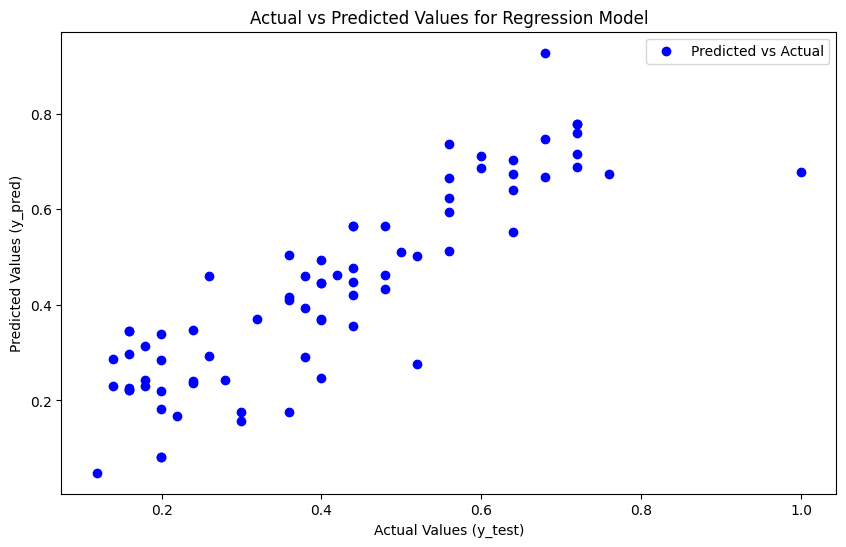

In [255]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter(test_target_salary_data, predictions, color='blue', label='Predicted vs Actual')
plt.xlabel('Actual Values (y_test)')
plt.ylabel('Predicted Values (y_pred)')
plt.title('Actual vs Predicted Values for Regression Model')
plt.legend()
plt.show()

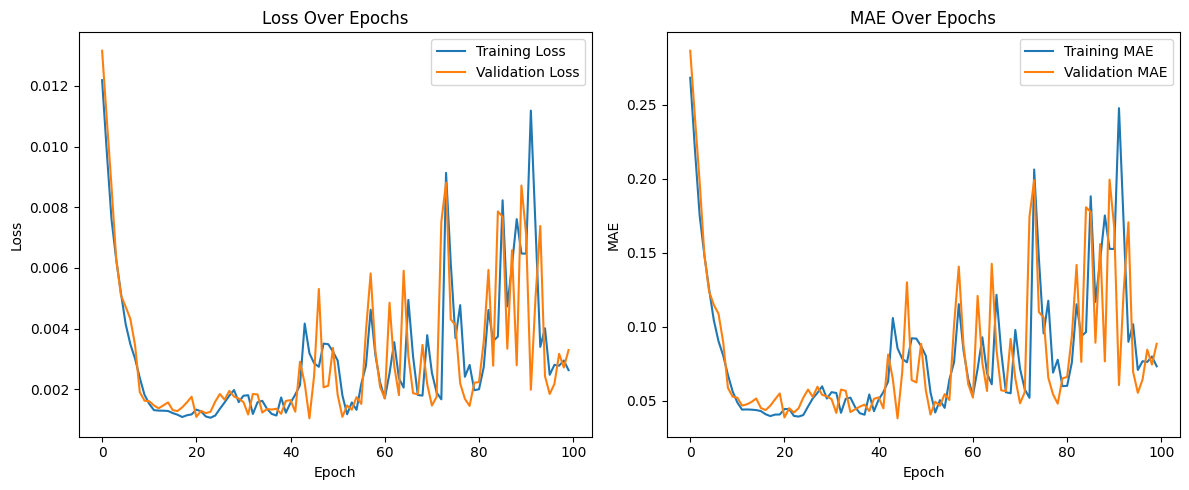

In [256]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mean_absolute_error'], label='Training MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.title('MAE Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

In [257]:
model.save('salary_model.keras')